In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tg584\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tg584\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tg584\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# read data
train = pd.read_csv('./data/train.txt', delimiter=';', header=None, names=['data', 'label'])
test = pd.read_csv('./data/test.txt', delimiter=';', header=None, names=['data', 'label'])
val = pd.read_csv('./data/val.txt', delimiter=';', header=None, names=['data', 'label'])
comb_data = pd.concat([train, val, test])
comb_data.shape

(20000, 2)

In [4]:
le = LabelEncoder()
comb_data['label_enc'] = le.fit_transform(comb_data['label'])
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [5]:
def tokenize_data(df):
    sents = df['data']
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = []
    for i in sents:
        tokens.append(tokenizer.tokenize(i.lower()))
    return tokens
tokenized = tokenize_data(comb_data)

In [6]:
def remove_stopwords(tokenized):
    sw = set(stopwords.words('english'))
    sw_removed = []
    for sent in tokenized:
        filtered = []
        for word in sent:
            if word not in sw:
                filtered.append(word)
        sw_removed.append(filtered)
    return sw_removed
stopwords_removed = remove_stopwords(tokenized)

In [7]:
def lemmatize(processed):
    lemma = WordNetLemmatizer()
    lemmatized = []
    for sent in processed:
        filtered = []
        for word in sent:
            filtered.append(lemma.lemmatize(word, pos='v'))
        lemmatized.append(filtered)
    return lemmatized
lemmatized = lemmatize(stopwords_removed)

In [8]:
final_data = []
# each l is a list of processed words
for l in lemmatized:
    final_data.append(' '.join(l))
d = {'data': final_data, 'label': comb_data['label_enc'], 'label_raw': comb_data['label']}
final_df = pd.DataFrame(data=d)

In [9]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [10]:
from sklearn.model_selection import train_test_split
def prepare_dataset(df, test_size=0.2, seq_len=30, embedding_dim=100):
    xtrain, xtest, ytrain, ytest = train_test_split(df['data'], df['label'], test_size=test_size, random_state=42)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['data'])
    word_inds = tokenizer.word_index
    vocab_size = len(word_inds) + 1

    ytrain = tf.keras.utils.to_categorical(ytrain, dtype='uint8')
    ytest = tf.keras.utils.to_categorical(ytest, dtype='uint8')

    xtrain = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=seq_len)
    xtest = pad_sequences(tokenizer.texts_to_sequences(xtest), maxlen=seq_len)
    print('x: ', xtrain.shape)
    print(xtest.shape)
    print('y: ', ytrain.shape)
    print(ytest.shape)
    print(vocab_size)
    return xtrain, xtest, ytrain, ytest, vocab_size

xtrain, xtest, ytrain, ytest, vocab_size = prepare_dataset(final_df)

x:  (16000, 30)
(4000, 30)
y:  (16000, 6)
(4000, 6)
13660


## CNN classifier

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Dense, GlobalMaxPooling1D, MaxPooling1D, Dropout, Embedding, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.python.ops.gen_batch_ops import batch

In [27]:
class CNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        # conv block 1
        model = Conv1D(128, 3, activation='relu')(model)
        model = Conv1D(128, 3, activation='relu')(model)
        model = MaxPooling1D()(model)

        # conv block 2
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(64, 3, activation='relu')(model)
        model = Dropout(0.2)(model)

        # conv block 3
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(32, 3, activation='relu')(model)
        model = GlobalMaxPooling1D()(model)

        # FC
        model = BatchNormalization()(model)
        model = Dense(512, activation='relu')(model)
        model = Dense(128, activation='relu')(model)
        model = Dropout(0.2)(model)

        # output
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs, name='cnn')

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.reduce_lr], verbose=1)
        return history

    def predict(self, data):
        # assume data is already cleaned
        return self.model.predict(data)

In [30]:
cnn = CNN(vocab_size)
history = cnn.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 1.5267 - accuracy: 0.3856 - auc: 0.7411 - val_loss: 5.6392 - val_accuracy: 0.3997 - val_auc: 0.6744
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 1.0253 - accuracy: 0.6007 - auc: 0.8931 - val_loss: 4.2628 - val_accuracy: 0.4882 - val_auc: 0.7042
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 0.7621 - accuracy: 0.7086 - auc: 0.9426 - val_loss: 1.1881 - val_accuracy: 0.6938 - val_auc: 0.9156
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.5356 - accuracy: 0.8139 - auc: 0.9708 - val_loss: 0.8595 - val_accuracy: 0.7325 - val_auc: 0.9406
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4403 - accuracy: 0.8501 - auc: 0.9795 - val_loss: 0.6996 - val_accuracy: 0.7427 - val_auc: 0.9563
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.3602 - accuracy: 0.8816 - auc: 0.9853 - val_loss: 0.7447 - v

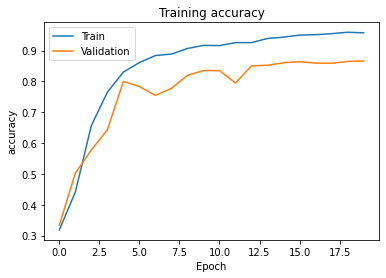

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
def plot_outs(history, name):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.title('Training '+name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

plot_outs(history, 'accuracy')


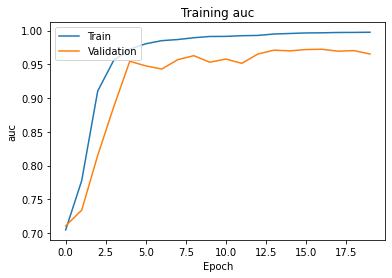

<Figure size 432x288 with 0 Axes>

In [15]:
plot_outs(history, 'auc')

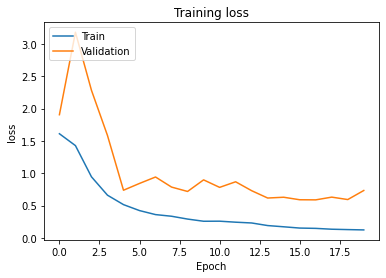

<Figure size 432x288 with 0 Axes>

In [16]:
plot_outs(history, 'loss')

In [17]:
from tensorflow.keras.layers import LSTM, Bidirectional
class RNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        model = Bidirectional(LSTM(4, input_shape=(self.seq_len, 1), return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4))(model)
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs)

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.early_stop, self.reduce_lr])
        return history


In [18]:
lstm = RNN(vocab_size)
history_lstm = lstm.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 13s 73ms/step - loss: 1.4230 - accuracy: 0.4396 - auc: 0.7817 - val_loss: 1.0769 - val_accuracy: 0.6202 - val_auc: 0.8816
Epoch 2/20
63/63 [==============================] - 3s 40ms/step - loss: 0.8691 - accuracy: 0.6905 - auc: 0.9202 - val_loss: 0.8311 - val_accuracy: 0.7057 - val_auc: 0.9276
Epoch 3/20
63/63 [==============================] - 2s 37ms/step - loss: 0.6418 - accuracy: 0.7527 - auc: 0.9569 - val_loss: 0.6170 - val_accuracy: 0.7610 - val_auc: 0.9606
Epoch 4/20
63/63 [==============================] - 2s 37ms/step - loss: 0.4827 - accuracy: 0.7959 - auc: 0.9751 - val_loss: 0.5694 - val_accuracy: 0.7812 - val_auc: 0.9661
Epoch 5/20
63/63 [==============================] - 2s 37ms/step - loss: 0.3951 - accuracy: 0.8309 - auc: 0.9826 - val_loss: 0.5354 - val_accuracy: 0.8183 - val_auc: 0.9697
Epoch 6/20
63/63 [==============================] - 2s 37ms/step - loss: 0.2946 - accuracy: 0.9026 - auc: 0.9903 - val_loss: 0.4490 - 

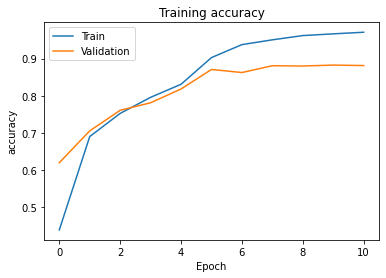

<Figure size 432x288 with 0 Axes>

In [19]:
plot_outs(history_lstm, 'accuracy')

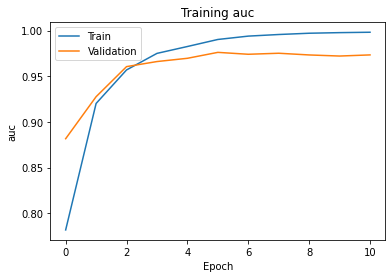

<Figure size 432x288 with 0 Axes>

In [20]:
plot_outs(history_lstm, 'auc')

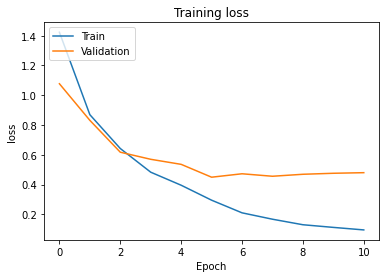

<Figure size 432x288 with 0 Axes>

In [21]:
plot_outs(history_lstm, 'loss')

# Results
LSTM performs better, but CNN runs faster

In [55]:
from sklearn.metrics import classification_report
pred = cnn.predict(xtest)
pred.shape

(4000, 6)

In [62]:
final_df['label_raw'].value_counts().sort_index()

anger       2709
fear        2373
joy         6761
love        1641
sadness     5797
surprise     719
Name: label_raw, dtype: int64

In [63]:
cm = classification_report(np.argmax(ytest, axis=1), np.argmax(pred, axis=1), target_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

In [64]:
print(cm)

              precision    recall  f1-score   support

       anger       0.87      0.89      0.88       540
        fear       0.82      0.78      0.80       442
         joy       0.93      0.91      0.92      1335
        love       0.68      0.79      0.73       332
     sadness       0.96      0.93      0.95      1195
    surprise       0.68      0.79      0.73       156

    accuracy                           0.89      4000
   macro avg       0.82      0.85      0.84      4000
weighted avg       0.89      0.89      0.89      4000

